In [1]:
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from scipy.special import comb

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/representation_stimuli/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 200) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

np.shape(images)

torch.Size([160, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 4521.5, -0.5)

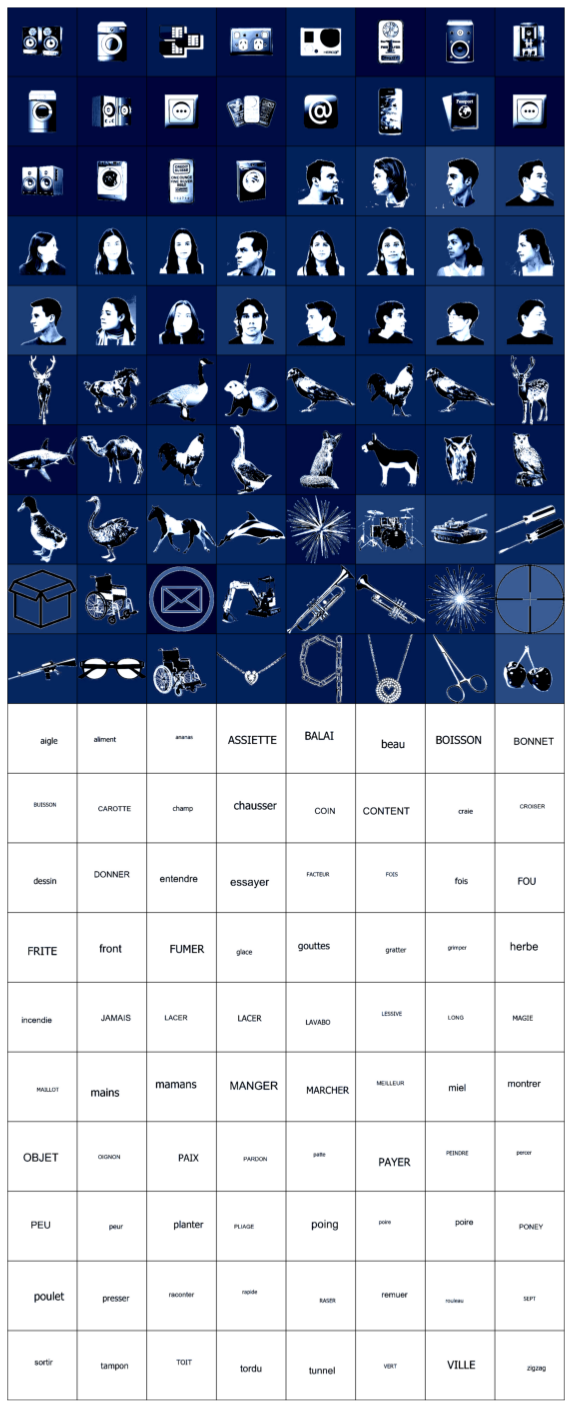

In [21]:
import torchvision

grid = torchvision.utils.make_grid(images)
plt.figure(figsize = (10,100))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')


In [3]:
stimtemp = images[:,:,:,:]

# Loading all the three network and extracting representation from all the hidden units
ili = {}
net = CORnet_Z_tweak()
checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())
ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())

Bli = {}
net = CORNet_Z_biased_words()
checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
Bli['v1'], Bli['v2'], Bli['v4'], Bli['it'], Bli['h'],  Bli['out'] = net(stimtemp.float())


nBli = {}
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)

nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())

1000
1000
[[1.         0.99946786 0.99950024]
 [0.99946786 1.         0.99996376]
 [0.99950024 0.99996376 1.        ]]
1000
1000
[[1.         0.99182912 0.99127979]
 [0.99182912 1.         0.99861525]
 [0.99127979 0.99861525 1.        ]]
1000
1000
[[1.         0.90580857 0.90956396]
 [0.90580857 1.         0.98846905]
 [0.90956396 0.98846905 1.        ]]
1000
1000
[[1.         0.242115   0.26492584]
 [0.242115   1.         0.84982385]
 [0.26492584 0.84982385 1.        ]]
1000
1000
[[1.         0.19929053 0.2001911 ]
 [0.19929053 1.         0.8389995 ]
 [0.2001911  0.8389995  1.        ]]
1000
1000
[[1.         0.15982881 0.1490128 ]
 [0.15982881 1.         0.84357275]
 [0.1490128  0.84357275 1.        ]]


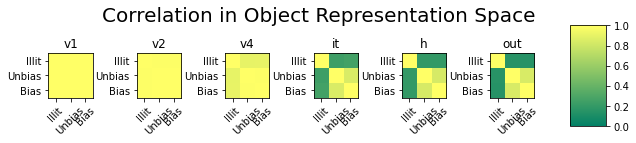

In [38]:
from sklearn.utils import resample

fig, axs = plt.subplots(1,6, figsize=(10,2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace=1)
axs = axs.ravel()

roi_ID = ['v1', 'v2', 'v4','it','h','out']; distMetric = 'euclidean'
for idx in range(len(roi_ID)):
    D = np.zeros((comb(np.size(stimtemp[80:,:],0), 2,exact =True),3)); 

    D[:,0] = squareform(pairwise_distances(ili[roi_ID[idx]].detach().numpy()[80:,:],metric = distMetric))
    D[:,1] = squareform(pairwise_distances(nBli[roi_ID[idx]].detach().numpy()[80:,:],metric = distMetric))
    D[:,2] = squareform(pairwise_distances(Bli[roi_ID[idx]].detach().numpy()[80:,:],metric = distMetric))

    Dcorr = 1-(pairwise_distances(D.T,metric = 'correlation'))
    im = axs[idx].imshow(Dcorr,vmin=0, vmax=1, cmap = 'summer')
    axs[idx].set_yticks([0,1,2]);     axs[idx].set_xticks([0,1,2])
    axs[idx].set_yticklabels(['Illit', 'Unbias','Bias'])
    axs[idx].set_xticklabels(['Illit', 'Unbias','Bias'], rotation = 45)
    axs[idx].set_title(roi_ID[idx])
    
    
    # configure bootstrap
    n_iterations = 1000
    # run bootstrap
    bstrpD = []
    for i in range(n_iterations):
        # prepare train and test sets
        Dsampled = resample(D, n_samples=np.size(D,0))
        bstrpD.append(1-(pairwise_distances(Dsampled.T,metric = 'correlation')))
    bstrpD = np.array(bstrpD)
    print(len(np.where(bstrpD[:,1,2] > bstrpD[:,0,1])[0])) # corr of unbias with (bias > illiterate)
    print(len(np.where(bstrpD[:,1,2] > bstrpD[:,0,2])[0])) # corr of  bias with (unbias > illiterate)
    print(np.mean(bstrpD,0))
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Correlation in Object Representation Space', fontsize=20)

plt.savefig("plots/objectRS.svg")



In [18]:
from sklearn.utils import resample
n_iterations = 1000
# run bootstrap
bstrpD = []
for i in range(n_iterations):
    # prepare train and test sets
    Dsampled = resample(D, n_samples=np.size(D,0))
    bstrpD.append(1-(pairwise_distances(Dsampled.T,metric = 'correlation')))
    


In [34]:
np.shape(bstrpD)


1
988
